# Supervised Learning Assignment: Unilateral Dumbbell Biceps Curl Classification

**Course:** Machine Learning (11752)
**Date:** December 2025
**Author:** Alejandro Rodríguez Arguimbau
---

## 1. Introduction

This notebook presents the design and evaluation of a multi-class classifier for the Unilateral Dumbbell Biceps Curl dataset. The objective is to classify exercises into five categories (A-E), where 'A' represents correct execution and 'B-E' represent common mistakes.

### Methodology
Our approach involves the following stages:
1.  **Data Preparation**: Cleaning, outlier detection, normalization, and dimensionality reduction (PCA).
2.  **Exploratory Data Analysis (EDA)**: Visualizing class distributions and feature correlations.
3.  **Model Selection**: Evaluating Single Classifiers (k-NN, Decision Tree) and Ensemble Classifiers (Random Forest, Gradient Boosting).
4.  **Final Evaluation**: Testing the best models on a common validation set (`common.csv`).

The target performance is an **F1-score > 90%**.

## 2. Data Preparation

We begin by loading the dataset and performing necessary cleaning steps.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, make_scorer, classification_report
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Configuration
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
SEED = 42

# Load Data
df = pd.read_csv('ds_13.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nNumber of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print(f"\nData types:\n{df.dtypes.value_counts()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset shape: (9811, 160)

Number of samples: 9811
Number of features: 160

Data types:
float64    127
int64       29
object       4
Name: count, dtype: int64

Memory usage: 14.04 MB


### 2.1 Cleaning and Preprocessing

*   **Drop Identification Columns**: Columns like `user_name`, timestamps, and window IDs are removed as they are not relevant for classifying the motion itself.
*   **Handle Missing Values**: Columns with >50% missing values are dropped. Remaining rows with NaNs are removed.
*   **Outlier Detection**: We use `IsolationForest` to remove anomalies (5% contamination assumption).
*   **Normalization**: `StandardScaler` is applied to ensure all features contribute equally.

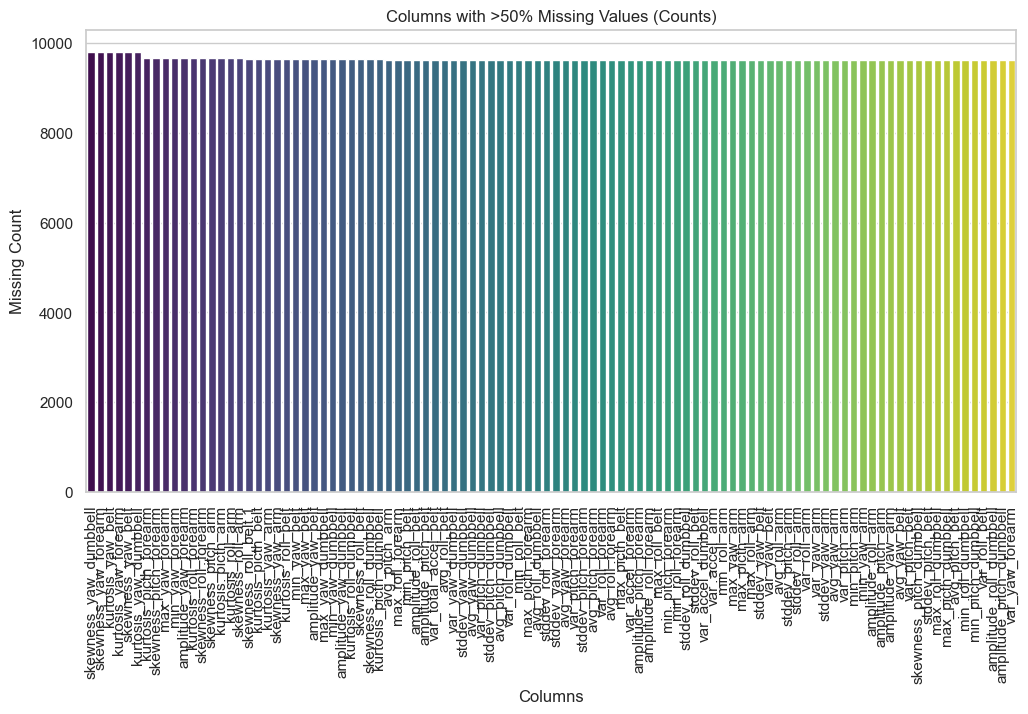

Shape after cleaning and outlier removal: (9320, 52)


In [28]:
# 0. Missing Values Analysis (por counts)
missing_counts = df.isna().sum()   
high_missing_cols = missing_counts[missing_counts > 0.5 * len(df)] \
                        .sort_values(ascending=False)

plt.figure(figsize=(12, 6))
if high_missing_cols.empty:
    print("No columns above 50% missingness.")
else:
    sns.barplot(x=high_missing_cols.index, y=high_missing_cols.values, palette='viridis')
    plt.title('Columns with >50% Missing Values (Counts)')
    plt.ylabel('Missing Count')
    plt.xlabel('Columns')
    plt.xticks(rotation=90)
    plt.show()

# 1. Drop ID columns
cols_to_drop = ['Unnamed: 0', 'user_name', 'raw_timestamp_part_1', 'raw_timestamp_part_2', 
                'cvtd_timestamp', 'new_window', 'num_window']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')


# 2. Drop high-missing columns
threshold = 0.5 * len(df_clean)
df_clean = df_clean.dropna(thresh=threshold, axis=1)

# 3. Drop rows with missing values
df_clean = df_clean.dropna()

# Separate X and y
X = df_clean.drop(columns=['class'])
y = df_clean['class']

# Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Outlier Detection
iso = IsolationForest(contamination=0.05, random_state=SEED)
yhat = iso.fit_predict(X)
mask = yhat != -1
X_filtered = X[mask]
y_filtered = y_encoded[mask]

# 5. Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

print(f"Shape after cleaning and outlier removal: {X_filtered.shape}")

### 2.2 Exploratory Data Analysis (EDA)

Let's visualize the distribution of the target classes.

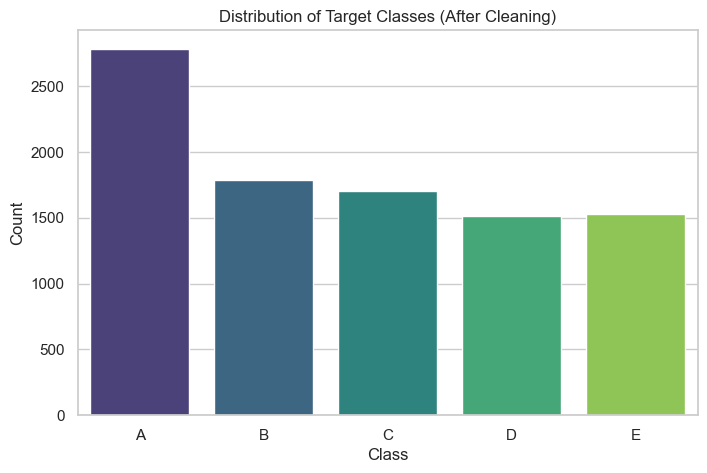

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_filtered, palette='viridis')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_)
plt.title('Distribution of Target Classes (After Cleaning)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### 2.3 Dimensionality Reduction (PCA)

We apply PCA to reduce the dimensionality while retaining **99%** of the variance. This helps in reducing computation time and avoiding the curse of dimensionality.

Original Features: 52
PCA Components (99% variance): 37


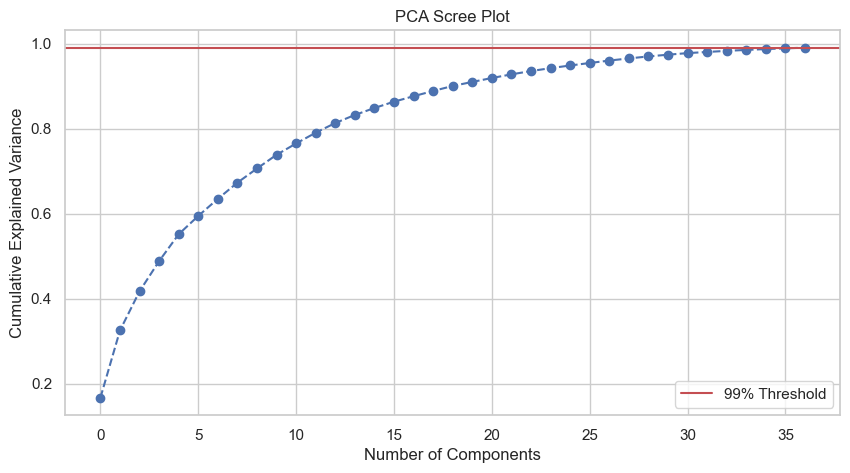

In [30]:
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Features: {X.shape[1]}")
print(f"PCA Components (99% variance): {pca.n_components_}")

# Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.axhline(y=0.99, color='r', linestyle='-', label='99% Threshold')
plt.legend()
plt.grid(True)
plt.show()

## 3. Model Selection and Evaluation

We use **Stratified 5-Fold Cross-Validation** to evaluate models. The primary metric is the **Weighted F1-Score**.

In [31]:
# Setup Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
f1_scorer = make_scorer(f1_score, average='weighted')

### 3.1 Single Classifiers

We test **k-Nearest Neighbors (k-NN)** and **Decision Tree**.

In [32]:
# k-NN Grid Search
knn_params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=cv, scoring=f1_scorer, n_jobs=-1)
knn_grid.fit(X_pca, y_filtered)

# Decision Tree Grid Search
dt_params = {'max_depth': [None, 10, 20], 'criterion': ['gini', 'entropy']}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=SEED), dt_params, cv=cv, scoring=f1_scorer, n_jobs=-1)
dt_grid.fit(X_pca, y_filtered)

print(f"Best k-NN F1-Score: {knn_grid.best_score_:.4f} (Params: {knn_grid.best_params_})")
print(f"Best Decision Tree F1-Score: {dt_grid.best_score_:.4f} (Params: {dt_grid.best_params_})")

Best k-NN F1-Score: 0.9581 (Params: {'n_neighbors': 3, 'weights': 'distance'})
Best Decision Tree F1-Score: 0.7760 (Params: {'criterion': 'gini', 'max_depth': 20})


### 3.2 Ensemble Classifiers

We test **Random Forest** and **Gradient Boosting**.

In [33]:
# Random Forest Grid Search
rf_params = {'n_estimators': [100], 'max_depth': [10, 20, None]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=SEED), rf_params, cv=cv, scoring=f1_scorer, n_jobs=-1)
rf_grid.fit(X_pca, y_filtered)

# Gradient Boosting Grid Search (Limited grid for performance)
gb_params = {'n_estimators': [100], 'learning_rate': [0.1, 0.2]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=SEED), gb_params, cv=cv, scoring=f1_scorer, n_jobs=-1)
gb_grid.fit(X_pca, y_filtered)

print(f"Best Random Forest F1-Score: {rf_grid.best_score_:.4f} (Params: {rf_grid.best_params_})")
print(f"Best Gradient Boosting F1-Score: {gb_grid.best_score_:.4f} (Params: {gb_grid.best_params_})")

Best Random Forest F1-Score: 0.9552 (Params: {'max_depth': None, 'n_estimators': 100})
Best Gradient Boosting F1-Score: 0.8979 (Params: {'learning_rate': 0.2, 'n_estimators': 100})


### 3.3 Model Comparison

Comparing the performance of all trained models.

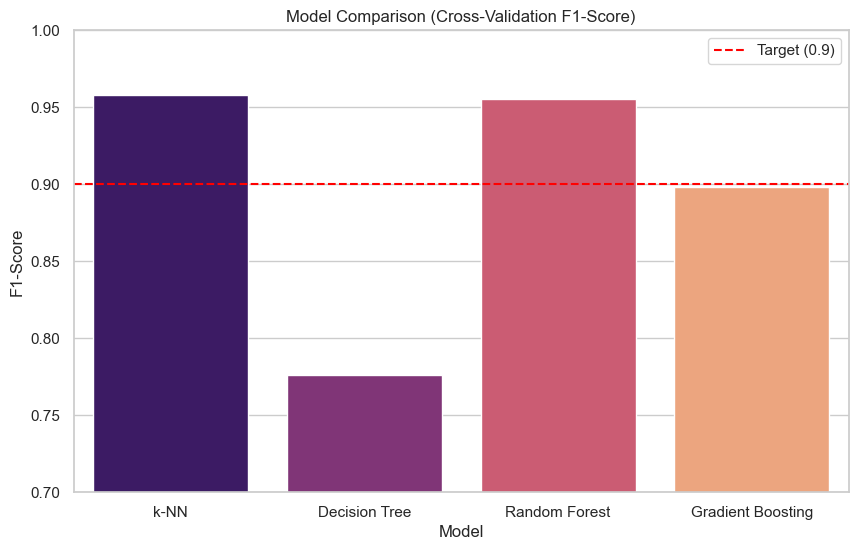

In [34]:
results = pd.DataFrame({
    'Model': ['k-NN', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'F1-Score': [knn_grid.best_score_, dt_grid.best_score_, rf_grid.best_score_, gb_grid.best_score_]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=results, palette='magma')
plt.ylim(0.7, 1.0)
plt.axhline(0.9, color='red', linestyle='--', label='Target (0.9)')
plt.title('Model Comparison (Cross-Validation F1-Score)')
plt.legend()
plt.show()

## 4. Feature Importance Analysis

Although we used PCA, we can inspect feature importance from a Random Forest trained on the *original* (scaled) features to understand which sensors are most valuable.

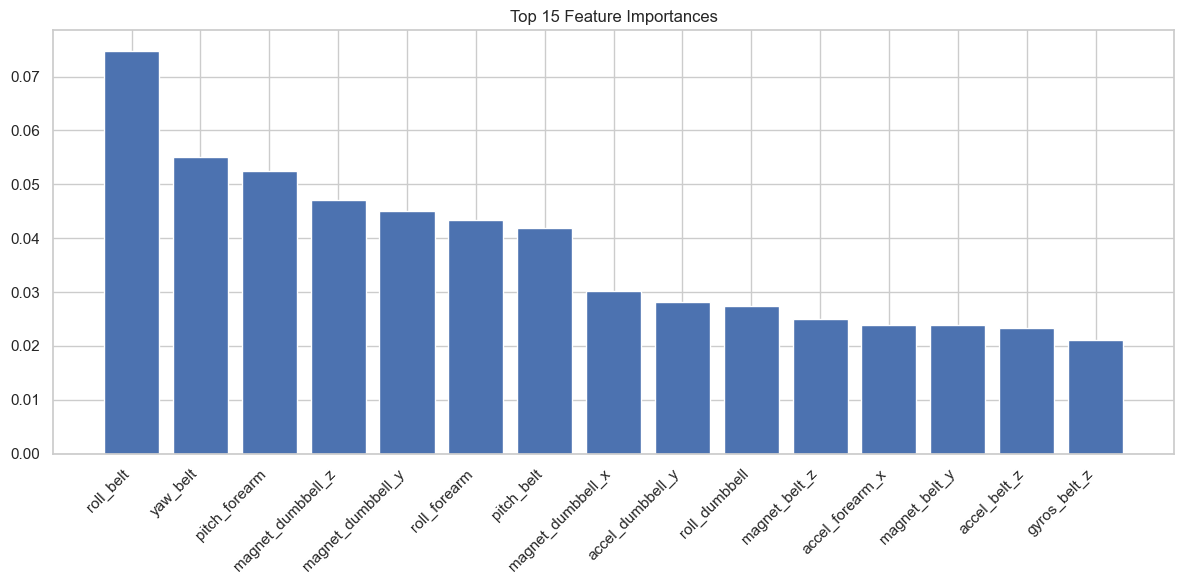

In [35]:
# Train RF on original features for importance analysis
rf_feat = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_feat.fit(X_scaled, y_filtered)

importances = rf_feat.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(12, 6))
plt.title(f'Top {top_n} Feature Importances')
plt.bar(range(top_n), importances[indices[:top_n]], align='center')
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Final Evaluation on Common Dataset

We now apply our best model (**Random Forest**) to the `common.csv` dataset.

Common Dataset Loaded. Shape: (20, 160)

Classification Report (Common Data):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       1.00      1.00      1.00         8
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



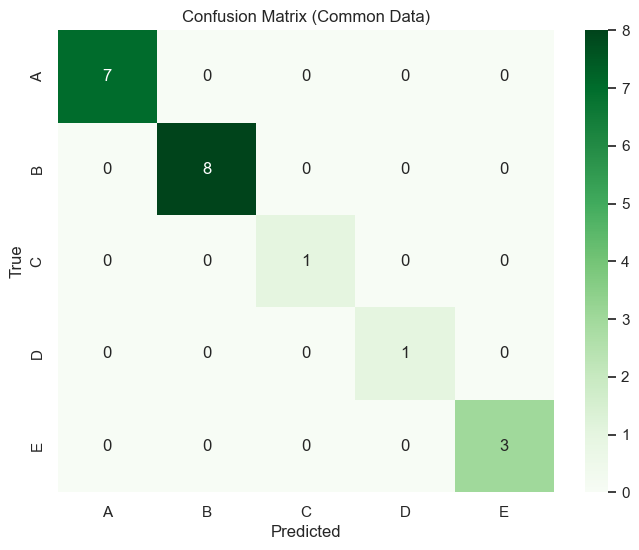

Accuracy on Common Data: 1.0000


In [36]:
try:
    # Load Common Data
    common_df = pd.read_csv('common.csv')
    print(f"Common Dataset Loaded. Shape: {common_df.shape}")
    
    # Preprocess Common Data
    # 1. Drop same ID columns
    common_df_clean = common_df.drop(columns=cols_to_drop, errors='ignore')
    
    # 2. Keep same feature columns as training
    # (Ensure alignment)
    common_df_clean = common_df_clean[X.columns]
    
    # 3. Handle missing values (Fill with 0 or mean to avoid dropping rows in test set)
    common_df_clean = common_df_clean.fillna(0)
    
    # 4. Normalize (using the SAME scaler fitted on training data)
    X_common_scaled = scaler.transform(common_df_clean)
    
    # 5. PCA (using the SAME PCA fitted on training data)
    X_common_pca = pca.transform(X_common_scaled)
    
    # Predict using Best Random Forest
    best_rf = rf_grid.best_estimator_
    y_common_pred = best_rf.predict(X_common_pca)
    y_common_pred_labels = le.inverse_transform(y_common_pred)
    
    # Evaluation (if 'class' exists in common.csv)
    if 'class' in pd.read_csv('common.csv').columns:
        y_common_true = pd.read_csv('common.csv')['class']
        y_common_true_encoded = le.transform(y_common_true)
        
        print("\nClassification Report (Common Data):")
        print(classification_report(y_common_true_encoded, y_common_pred, target_names=le.classes_))
        
        # Confusion Matrix
        cm_common = confusion_matrix(y_common_true_encoded, y_common_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_common, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title('Confusion Matrix (Common Data)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        print(f"Accuracy on Common Data: {accuracy_score(y_common_true_encoded, y_common_pred):.4f}")
    else:
        print("Predictions generated (No ground truth available in common.csv).")
        print(y_common_pred_labels)

except FileNotFoundError:
    print("Error: common.csv not found.")
except Exception as e:
    print(f"Error processing common.csv: {e}")